In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython.display import HTML

In [2]:
# SEED = 32
# SEED = 64
SEED = 128
NUM_ITERS = 50

In [3]:
def get_loss(x, y):
    def gaussian_hills(x, y, x_mean, y_mean, x_sig, y_sig):
        normalizing = 1 / (2 * np.pi * x_sig * y_sig)
        x_exp = (-1 * (x - x_mean) ** 2) / (2 * x_sig ** 2)
        y_exp = (-1 * (y - y_mean) ** 2) / (2 * y_sig ** 2)
        return normalizing * tf.exp(x_exp + y_exp)
    loss = 0
    n_hills = 10
    np.random.seed(SEED)
    weights = np.random.uniform(-1.0, 0.2, n_hills)
    x_means = np.random.uniform(-1., 1., n_hills)
    y_means = np.random.uniform(-1., 1., n_hills)
    x_sigmas = np.random.uniform(0.2, 0.8, n_hills)
    y_sigmas = np.random.uniform(0.2, 0.8, n_hills)
    for i in range(n_hills):
        loss += weights[i] * gaussian_hills(x, y, x_means[i], y_means[i], x_sigmas[i], y_sigmas[i])
    return loss

In [4]:
def build_graph(start_x=0.0, start_y=0.0):
    tf.reset_default_graph()
    x_var = tf.get_variable(name="x", shape=(), dtype=tf.float32, initializer=tf.constant_initializer(start_x))
    y_var = tf.get_variable(name="y", shape=(), dtype=tf.float32, initializer=tf.constant_initializer(start_y))
    loss = get_loss(x_var, y_var)
    adam_opt = tf.train.AdamOptimizer(1e-1).minimize(loss, var_list=[x_var, y_var], name="Adam")
    rmsprop_opt = tf.train.RMSPropOptimizer(1e-1).minimize(loss, var_list=[x_var, y_var], name="RMSProp")
    momentum_opt = tf.train.MomentumOptimizer(1e-1, momentum=0.9).minimize(loss, var_list=[x_var, y_var], name="Momentum")
    nag_opt = tf.train.MomentumOptimizer(1e-1, momentum=0.9, use_nesterov=True).minimize(loss, var_list=[x_var, y_var], name="NAG")
    adagrad_opt = tf.train.AdagradOptimizer(1e-1).minimize(loss, var_list=[x_var, y_var], name="Adagrad")
    adadelta_opt = tf.train.AdadeltaOptimizer(1e-1).minimize(loss, var_list=[x_var, y_var], name="Adadelta")
    sgd_opt = tf.train.GradientDescentOptimizer(1e-1).minimize(loss, var_list=[x_var, y_var], name="GradientDecent")
    
    colors = "bgrcmykw"
    optimizers = list()
    for i, opt in enumerate([adam_opt, rmsprop_opt, momentum_opt, adagrad_opt, adadelta_opt, sgd_opt, nag_opt]):
        optimizers.append({"opt": opt, "name": opt.name, "lr": 0.1, "trajectory": list(), "color": colors[i]})
    return x_var, y_var, loss, optimizers

In [5]:
def plot_surface():
    s = 50
    x_lb, x_ub = -1.5, 1.5
    y_lb, y_ub = -1.5, 1.5
    
    x = np.arange(x_lb, x_ub, (x_ub - x_lb) / s)
    y = np.arange(y_lb, y_ub, (y_ub - y_lb) / s)
    x, y = np.meshgrid(x, y)
    x, y = x.reshape(-1), y.reshape(-1)
    loss = get_loss(x, y)

    tf.reset_default_graph()
    with tf.Session() as sess:
        loss = sess.run(get_loss(x, y))
    x = x.reshape((s, s))
    y = y.reshape((s, s))
    loss = loss.reshape((s, s))

    fig = plt.figure(figsize=(10, 8))
    ax = Axes3D(fig)
    ax._axis3don = False
    ax.plot_surface(x, y, loss, rstride=1, cstride=1, cmap=plt.get_cmap("coolwarm"), alpha=0.6, zorder=0)
    r = loss.max() - loss.min()
    ax.set_zlim(loss.min() - 0.8 * r, loss.max() + 0.8 * r)
    ax.set_xlim(x_lb, x_ub)
    ax.set_ylim(y_lb, y_ub)
    ax.view_init(elev=45, azim=45)
    return fig, ax

In [6]:
def get_peak():
    s = 50
    x_lb, x_ub = -1.5, 1.5
    y_lb, y_ub = -1.5, 1.5
    
    x = np.arange(x_lb, x_ub, (x_ub - x_lb) / s)
    y = np.arange(y_lb, y_ub, (y_ub - y_lb) / s)
    x, y = np.meshgrid(x, y)
    x, y = x.reshape(-1), y.reshape(-1)
    loss = get_loss(x, y)

    tf.reset_default_graph()
    with tf.Session() as sess:
        loss = sess.run(get_loss(x, y))
    idx = np.argmax(loss)
    return x[idx], y[idx]

1.4400000000000026 1.4400000000000026


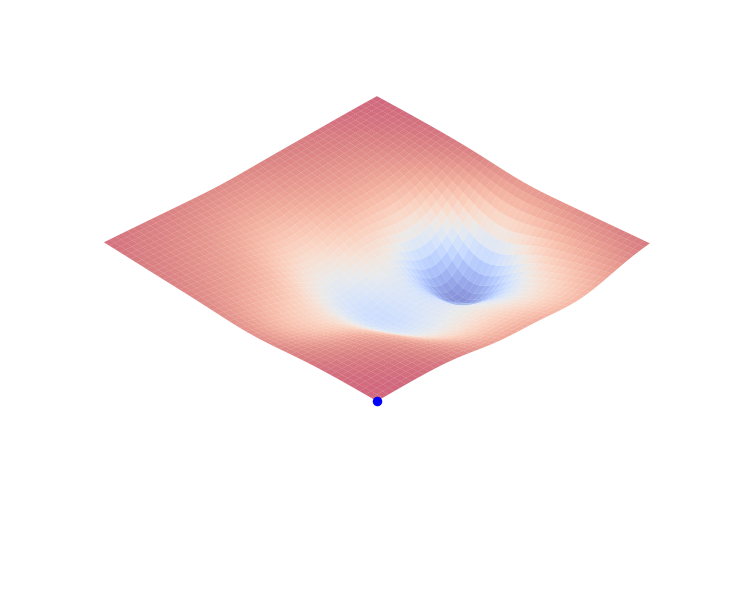

In [7]:
start_x, start_y = get_peak()
print(start_x, start_y)
fig, ax = plot_surface()
tf.reset_default_graph()
with tf.Session() as sess:
    start_z = sess.run(get_loss(start_x, start_y))
ax.scatter(start_x, start_y, start_z, color="blue", zorder=10, linewidth=5)

In [8]:
x_var, y_var, loss_var, optimizers = build_graph(start_x, start_y)
with tf.Session() as sess:
    for opt in optimizers:
        sess.run(tf.global_variables_initializer())
        opt["trajectory"].append(sess.run([x_var, y_var, loss_var]))        
        for _ in range(NUM_ITERS):
            sess.run(opt["opt"])
            opt["trajectory"].append(sess.run([x_var, y_var, loss_var]))

W0908 19:17:26.706516 4623541696 deprecation.py:323] From /Users/abbo/anaconda3/envs/lab/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0908 19:17:28.208874 4623541696 deprecation.py:506] From /Users/abbo/anaconda3/envs/lab/lib/python3.6/site-packages/tensorflow/python/training/rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0908 19:17:30.444285 4623541696 deprecation.py:506] From /Users/abbo/anaconda3/envs/lab/lib/python3.6/site-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops

### plot loss curve

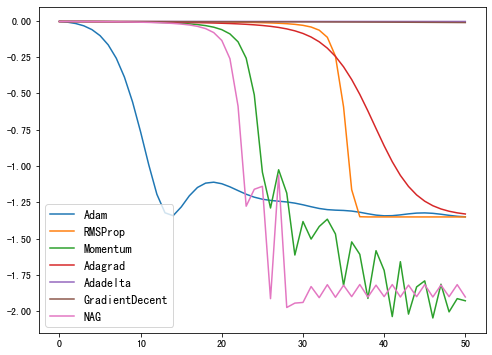

In [9]:
plt.figure(figsize=(8, 6))
for opt in optimizers:
    plt.plot(np.asarray(opt["trajectory"])[:, 2], label=opt["name"])
plt.legend(prop={"size": 12})
plt.show()

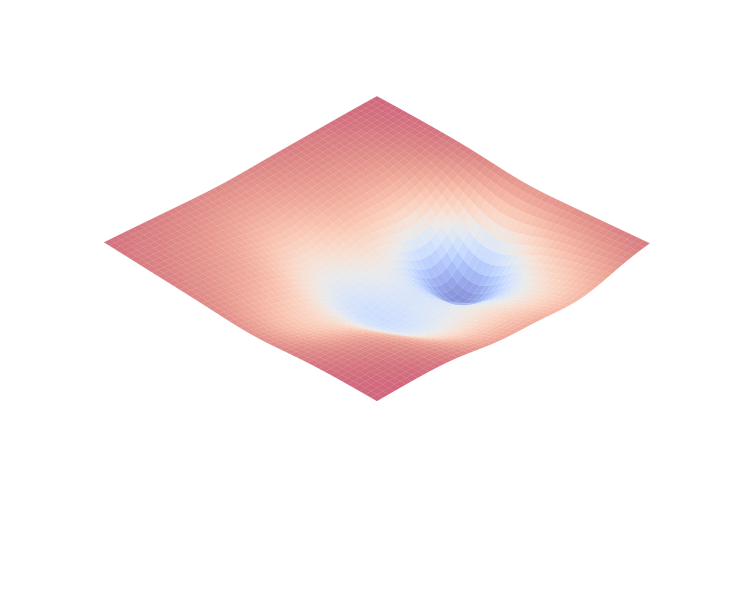

In [10]:
fig, ax = plot_surface()

In [11]:
def plot_trajectories(fig, ax, optimizers):

def update_fig(i):
    global scatters
    for j, opt in enumerate(optimizers):
        if scatters[j] is not None:
            scatters[j].remove()
        scat = ax.scatter(*zip(opt["trajectory"][i+1]), zorder=10, linewidth=4, color=opt["color"])
        scatters[j] = scat
        ln = ax.plot(*zip(opt["trajectory"][i], opt["trajectory"][i+1]), color=opt["color"], zorder=10, label=opt["name"], linewidth=2)
    return ln,

def init_fig():
    for opt in optimizers:
        ln = ax.scatter(*opt["trajectory"][0], color=opt["color"], zorder=10, label="%s (%.2f)" % (opt["name"], opt["lr"]))
    ax.legend(prop={'size': 15})
    return ()

global scatters
scatters = [None for _ in range(len(optimizers))]
anim = FuncAnimation(fig, update_fig, frames=NUM_ITERS-1, interval=10, init_func=init_fig, repeat=True)
return anim

In [12]:
anim = plot_trajectories(fig, ax, optimizers)
HTML(anim.to_html5_video())
# anim.save('optimization_methods_%s.mp4' % SEED, dpi=30, writer='imagemagick')